# Insights com Machine Learning

## Importando bibliotecas e lendo o dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
merged = pd.read_csv('../data/processed/dataset_merged.csv')

## Prever a avaliação do cliente (review_score)

### Criar a variável alvo (ruim vs bom)

* Notas 1 ou 2 -> **Insatisfeito** (0)
* Notas 4 ou 5 -> **Satisfeito** (1)
* Nota 3 -> **Neutro** (Será removido do dataset)

In [3]:
df_rev = merged.copy()  # só para não mexer no original

df_rev["review_score"] = pd.to_numeric(df_rev["review_score"], errors="coerce")

df_rev["review_target"] = df_rev["review_score"].apply(
   lambda x: 0 if x in [1, 2] else (1 if x in [4, 5] else None)
)

# remover notas neutras (3) e faltantes
df_rev = df_rev.dropna(subset=["review_target"])
df_rev["review_target"] = df_rev["review_target"].astype(int)

In [4]:
df_rev["review_target"].value_counts(normalize=True)

review_target
1    0.823805
0    0.176195
Name: proportion, dtype: float64

### Criar as features básicas que vamos usar

* atraso ou não (is_delayed)
* tempo de entrega (delivery_days)
* tipo de pagamento (payment_type)
* parcelas (payment_installments)
* preço (price)
* valor do frete (freight_value)
* total pago (payment_value)
* estado do cliente (customer_state)

#### is_delayed

In [5]:
merged["order_purchase_timestamp"] = pd.to_datetime(
   merged["order_purchase_timestamp"], errors="coerce"
)

merged["order_delivered_customer_date"] = pd.to_datetime(
   merged["order_delivered_customer_date"], errors="coerce"
)

merged["delivery_days"] = (
   merged["order_delivered_customer_date"] -
   merged["order_purchase_timestamp"]
).dt.days

df_delay = merged[
   (merged["order_status"] == "delivered") &
   (merged["delivery_days"].notna())
].copy()

In [6]:
len(df_delay)

114851

In [7]:
median_time = (
   df_delay
   .groupby("customer_state")["delivery_days"]
   .median()
   .reset_index()
   .rename(columns={"delivery_days": "expected_days"})
)

In [8]:
median_time.head()

,customer_state,expected_days
0,AC,18.0
1,AL,21.0
2,AM,26.0
3,AP,24.0
4,BA,16.0


In [9]:
df_delay = df_delay.merge(
   median_time,
   on="customer_state",
   how="left"
)

df_delay["delay_gap"] = df_delay["delivery_days"] - df_delay["expected_days"]
df_delay["is_delayed"] = (df_delay["delay_gap"] > 3).astype(int)
df_delay["is_delayed"].value_counts(normalize=True)

is_delayed
0    0.715423
1    0.284577
Name: proportion, dtype: float64

#### Garantir que review_score está numérico

In [10]:
df_delay["review_score"] = pd.to_numeric(df_delay["review_score"], errors="coerce")

#### Criar o alvo binário review_target

In [11]:
df_delay["review_target"] = df_delay["review_score"].apply(
   lambda x: 0 if x in [1, 2] else (1 if x in [4, 5] else None)
)

In [12]:
df_delay = df_delay.dropna(subset=["review_target"])
df_delay["review_target"] = df_delay["review_target"].astype(int)

In [13]:
df_delay["review_target"].value_counts(normalize=True)

review_target
1    0.838283
0    0.161717
Name: proportion, dtype: float64

#### Criar as features para o modelo

In [14]:
cols_features = [
   "delivery_days",
   "is_delayed",
   "payment_type",
   "payment_installments",
   "price",
   "freight_value",
   "payment_value",
   "customer_state"
]

df_model_rev = df_delay[cols_features + ["review_target"]].dropna().copy()

In [15]:
df_model_rev.head()

,delivery_days,is_delayed,payment_type,payment_installments,price,freight_value,payment_value,customer_state,review_target
0,8.0,0,credit_card,1,29.99,8.72,18.12,SP,1
1,8.0,0,voucher,1,29.99,8.72,2.00,SP,1
2,8.0,0,voucher,1,29.99,8.72,18.59,SP,1
3,13.0,0,boleto,1,118.70,22.76,141.46,BA,1
4,9.0,0,credit_card,3,159.90,19.22,179.12,GO,1


#### Transformar categorias em dummies

In [16]:
X = df_model_rev[cols_features]
y = df_model_rev["review_target"]

X_encoded = pd.get_dummies(
   X,
   columns=["payment_type", "customer_state"],
   drop_first=True
)

In [17]:
X_encoded.dtypes

delivery_days               float64
is_delayed                    int64
payment_installments          int64
price                       float64
freight_value               float64
payment_value               float64
payment_type_credit_card       bool
payment_type_debit_card        bool
payment_type_voucher           bool
customer_state_AL              bool
customer_state_AM              bool
customer_state_AP              bool
customer_state_BA              bool
customer_state_CE              bool
customer_state_DF              bool
customer_state_ES              bool
customer_state_GO              bool
customer_state_MA              bool
customer_state_MG              bool
customer_state_MS              bool
customer_state_MT              bool
customer_state_PA              bool
customer_state_PB              bool
customer_state_PE              bool
customer_state_PI              bool
customer_state_PR              bool
customer_state_RJ              bool
customer_state_RN           

#### Separar treino e teste

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
   X_encoded, y,
   test_size=0.2,
   random_state=42,
   stratify=y
)

### Modelos

#### Regressão logística

##### Importar o modelo

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

##### Criar e treinar a regressão logística

In [20]:
log_clf = LogisticRegression(
   max_iter=2000,
   solver="liblinear",
   class_weight="balanced"   # importante, porque o dataset é desbalanceado
)

log_clf.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'liblinear'
,max_iter,2000
,multi_class,'deprecated'


##### Fazer previsões

In [21]:
y_pred_log = log_clf.predict(X_test)

##### Avaliar

In [22]:
print("Acurácia:", accuracy_score(y_test, y_pred_log))
print()
print(classification_report(y_test, y_pred_log))

Acurácia: 0.7434532579250036

              precision    recall  f1-score   support

           0       0.33      0.56      0.41      3403
           1       0.90      0.78      0.84     17638

    accuracy                           0.74     21041
   macro avg       0.62      0.67      0.63     21041
weighted avg       0.81      0.74      0.77     21041



##### Matriz de confusão

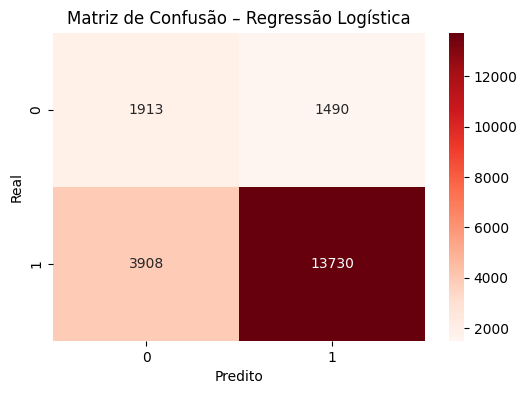

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Reds", fmt="d")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão – Regressão Logística")
plt.show()

A regressão logística, mesmo simples, já detecta mais de metade das avaliações ruins e acerta facilmente as boas. Isso prova que há padrão real no comportamento do cliente e que vale a pena testar modelos mais robustos.

#### Randon Forest

##### Importar e treinar o RF

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
   n_estimators=300,
   max_depth=None,
   random_state=42,
   n_jobs=-1,
   class_weight="balanced"
)

rf_clf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


##### Prever

In [26]:
y_pred_rf = rf_clf.predict(X_test)

##### Avaliar

In [27]:
from sklearn.metrics import accuracy_score, classification_report

print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print()
print(classification_report(y_test, y_pred_rf))

Acurácia: 0.8975809134546837

              precision    recall  f1-score   support

           0       0.82      0.47      0.60      3403
           1       0.91      0.98      0.94     17638

    accuracy                           0.90     21041
   macro avg       0.86      0.73      0.77     21041
weighted avg       0.89      0.90      0.89     21041



##### Matriz de confusão

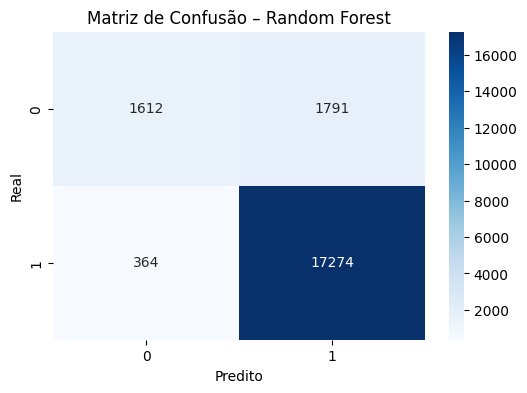

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão – Random Forest")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

O Random Forest apresentou um desempenho significativamente superior aos modelos anteriores, especialmente na identificação de clientes satisfeitos. Embora ainda enfrente alguma dificuldade para prever avaliações negativas, ele demonstrou melhor capacidade de capturar os padrões complexos do comportamento do consumidor, que envolvem atraso, preço, frete, estado e forma de pagamento. No conjunto, o modelo se mostrou mais robusto e mais sensível às relações não lineares presentes no dataset, oferecendo uma previsão mais confiável das notas atribuídas pelos clientes.

#### XGBoost

##### Importar e treinar o XGB

In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

xgb = XGBClassifier(
   n_estimators=300,
   learning_rate=0.05,
   max_depth=6,
   subsample=0.8,
   colsample_bytree=0.8,
   random_state=42,
   eval_metric="logloss"
)

xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)


##### Avaliar

In [30]:
print("Acurácia:", accuracy_score(y_test, pred_xgb))
print(classification_report(y_test, pred_xgb))

Acurácia: 0.8700632099234827
              precision    recall  f1-score   support

           0       0.77      0.28      0.41      3403
           1       0.88      0.98      0.93     17638

    accuracy                           0.87     21041
   macro avg       0.82      0.63      0.67     21041
weighted avg       0.86      0.87      0.84     21041



##### Matriz de confusão

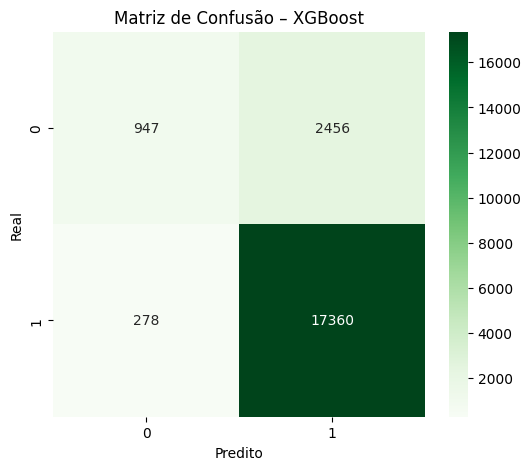

In [31]:
cm = confusion_matrix(y_test, pred_xgb)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusão – XGBoost")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


O XGBoost apresentou alto desempenho geral, mas com um comportamento enviesado em relação à classe majoritária. Ele foi extremamente eficiente para identificar clientes satisfeitos, alcançando recall de 0.98 nessa classe. Por outro lado, teve dificuldade em reconhecer avaliações negativas, o que aparece tanto na queda do recall da classe 0 quanto no grande número de falsos positivos. Esse padrão sugere que o modelo aprende muito bem os sinais associados a boas avaliações, mas não consegue capturar com a mesma precisão os fatores que levam à insatisfação. Ainda assim, o XGBoost se mostrou robusto e competitivo, embora menos equilibrado que o Random Forest no cenário atual.

## **Comparação Detalhada dos Modelos de Classificação para Previsão de Satisfação do Cliente**

A seguir está uma análise mais extensa que compara Regressão Logística, Random Forest e XGBoost. A interpretação considera os resultados de acurácia, precisão, recall, F1 e os padrões identificados nas matrizes de confusão.

---

**1. Tabela comparativa das métricas**

| Modelo               | Acurácia | Precisão (classe 0) | Recall (classe 0) | F1 (classe 0) | Precisão (classe 1) | Recall (classe 1) | F1 (classe 1) |
|----------------------|----------|----------------------|--------------------|----------------|----------------------|--------------------|----------------|
| Regressão Logística  | 0.74     | 0.33                 | 0.56               | 0.41           | 0.90                 | 0.78               | 0.84           |
| Random Forest        | 0.90     | 0.82                 | 0.47               | 0.60           | 0.91                 | 0.98               | 0.94           |
| XGBoost              | 0.87     | 0.77                 | 0.28               | 0.41           | 0.88                 | 0.98               | 0.93           |


Observação importante: a classe 0 representa clientes insatisfeitos (nota 1 ou 2). A classe 1 representa clientes satisfeitos (nota 4 ou 5).

---

**2. Tabela comparativa das matrizes de confusão**


**Regressão Logística**
| Real \ Predito | 0    | 1     |
|----------------|------|-------|
| 0              | 1913 | 1490  |
| 1              | 3908 | 13730 |

**Random Forest**
| Real \ Predito | 0    | 1     |
|----------------|------|-------|
| 0              | 1612 | 1791  |
| 1              | 364  | 17274 |

**XGBoost**
| Real \ Predito | 0    | 1     |
|----------------|------|-------|
| 0              | 947  | 2456  |
| 1              | 278  | 17360 |

---

**3. Interpretação detalhada dos resultados**

**Regressão Logística**

Esse modelo apresentou o desempenho mais modesto entre os três. Ele acerta a maior parte dos clientes satisfeitos, porém falha com frequência ao identificar clientes insatisfeitos. O recall da classe 0 alcança apenas 0.56, e a precisão é baixa. Na prática, a regressão tende a prever que o cliente está satisfeito mesmo quando não está. Isso mostra que o limite de separação linear não é suficiente para capturar a complexidade da relação entre atraso, frete, preço e avaliação final.

**Random Forest**

Entre os três modelos, o Random Forest foi o mais equilibrado e consistente. Ele combinou excelente desempenho na classe majoritária com um ganho real na detecção de clientes insatisfeitos. Embora o recall da classe 0 ainda não seja ideal, ele supera com folga o XGBoost. A precisão da classe 1 é alta, e o recall chega a 0.98, que indica forte capacidade de reconhecer avaliações positivas. Isso sugere que o modelo consegue entender bem as interações entre preço, frete e tempo de entrega, já que árvores capturam relações não lineares de maneira natural.

**XGBoost**

O XGBoost alcançou acurácia alta e recall excepcional para a classe positiva, porém teve desempenho fraco na identificação de clientes insatisfeitos. A matriz de confusão revela um padrão muito claro: o modelo prefere prever que o cliente está satisfeito. Isso é típico de cenários desbalanceados quando o modelo converge para a classe majoritária como estratégia para maximizar acurácia. Embora mantenha ótimo desempenho para prever boas avaliações, ele sacrifica a sensibilidade da classe negativa, o que o torna menos útil para identificar situações problemáticas.

---

**4. Conclusão comparativa final**

O Random Forest se mostrou o modelo mais adequado para prever a satisfação dos clientes. Ele apresenta equilíbrio entre as classes, boa acurácia geral e maior sensibilidade para detectar avaliações negativas. A regressão logística oferece uma solução simples e interpretável, mas perde muito desempenho diante da complexidade do problema. O XGBoost tem força em acurácia global e na classe majoritária, no entanto falha em identificar clientes insatisfeitos, que é justamente onde o modelo mais pode agregar valor para o negócio.